<>:156: SyntaxWarning: invalid escape sequence '\.'
<>:156: SyntaxWarning: invalid escape sequence '\.'
C:\Users\HP\AppData\Local\Temp\ipykernel_22272\578630348.py:156: SyntaxWarning: invalid escape sequence '\.'
  df_clean['Title'] = df_clean['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


=== DATASET OVERVIEW ===
Dataset shape: (891, 12)

First 5 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123  

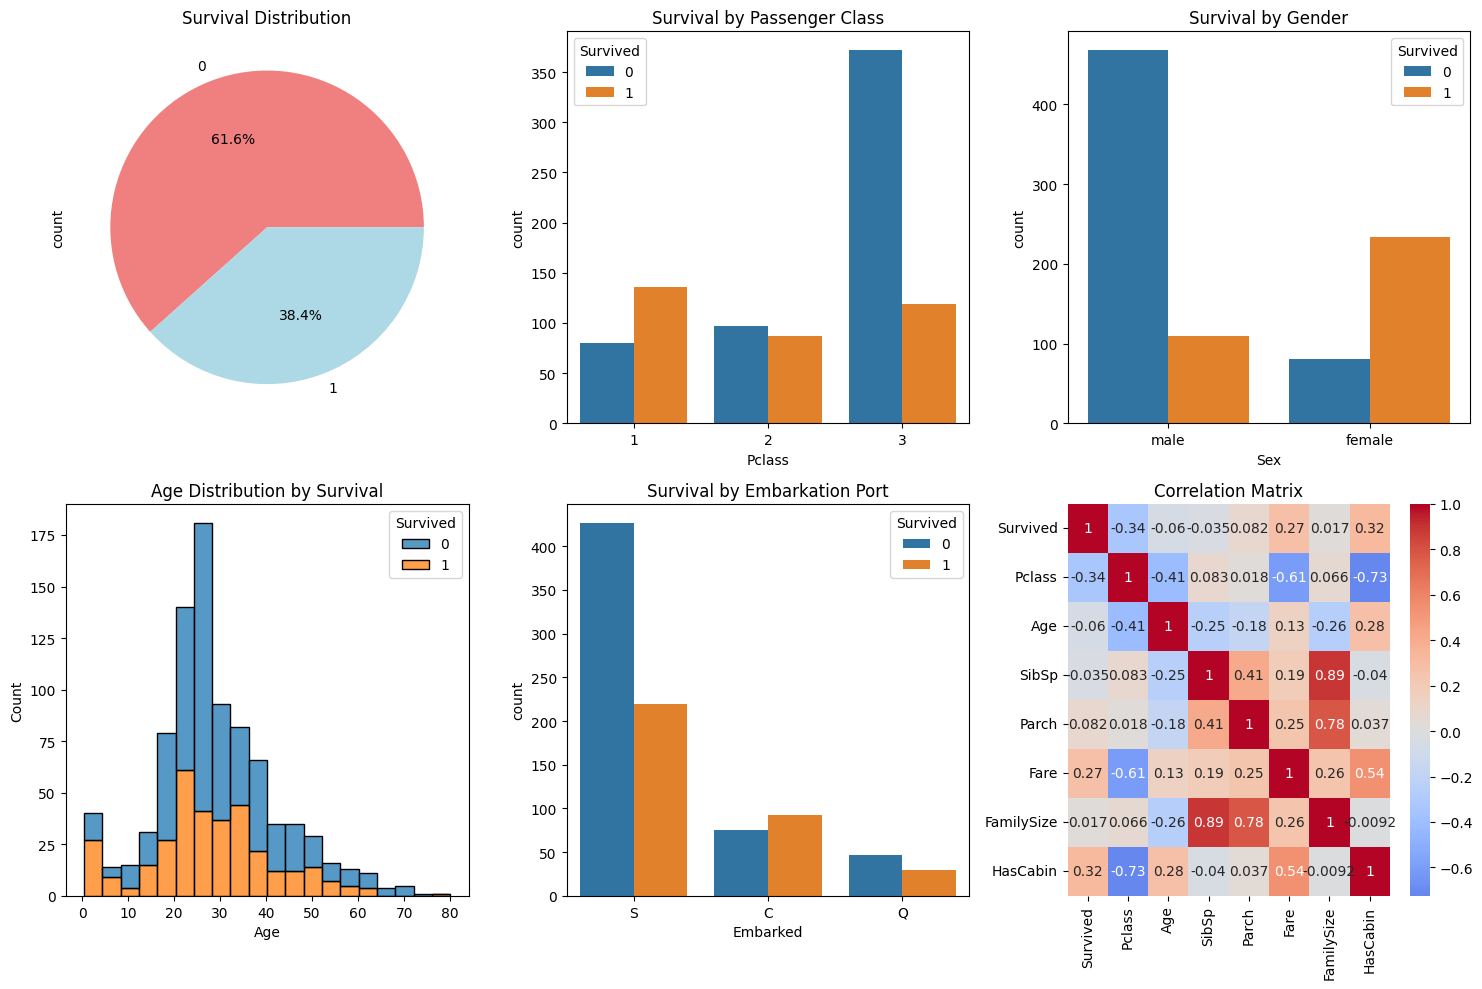

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Titanic-Dataset.csv')

print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nDataset info:")
print(df.info())

print(f"\nBasic statistics:")
print(df.describe(include='all'))

print("\n" + "="*50)
print("=== DATA QUALITY CHECKS ===")
print("="*50)

# 1. Check for missing values
print("\n1. MISSING VALUES ANALYSIS:")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
print(missing_info[missing_info['Missing Count'] > 0])

# 2. Check for duplicates
print(f"\n2. DUPLICATE RECORDS:")
print(f"Total duplicate rows: {df.duplicated().sum()}")

# Check for duplicates based on key columns (excluding PassengerId which is unique)
key_columns = ['Name', 'Age', 'Ticket', 'Fare']
print(f"Potential duplicates based on key columns: {df.duplicated(subset=key_columns).sum()}")

# 3. Data type analysis
print(f"\n3. DATA TYPES:")
print(df.dtypes)

print("\n" + "="*50)
print("=== DETAILED COLUMN ANALYSIS ===")
print("="*50)

# Analyze each column individually
columns_to_analyze = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']

for col in columns_to_analyze:
    print(f"\n--- {col.upper()} ---")
    if col in df.columns:
        if df[col].dtype in ['object', 'category']:
            # Categorical column analysis
            value_counts = df[col].value_counts()
            print(f"Unique values: {df[col].nunique()}")
            print("Value counts:")
            print(value_counts.head(10))  # Show top 10 values
            if df[col].nunique() > 10:
                print(f"... and {df[col].nunique() - 10} more unique values")
        else:
            # Numerical column analysis
            print(f"Data type: {df[col].dtype}")
            print(f"Missing values: {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.2f}%)")
            if df[col].notna().sum() > 0:  # Only show stats if there are non-null values
                print(f"Min: {df[col].min()}, Max: {df[col].max()}")
                print(f"Mean: {df[col].mean():.2f}, Median: {df[col].median():.2f}")
                
                # Check for outliers using IQR method
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
                print(f"Potential outliers: {len(outliers)}")

# Special analysis for Age column
print(f"\n--- AGE DISTRIBUTION DETAILS ---")
print(f"Age range: {df['Age'].min()} to {df['Age'].max()} years")
print(f"Age groups:")
age_bins = [0, 12, 18, 35, 60, 100]
age_labels = ['Child', 'Teen', 'Adult', 'Middle-aged', 'Senior']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
print(df['AgeGroup'].value_counts())

print("\n" + "="*50)
print("=== DATA CLEANING PROCESS ===")
print("="*50)

# Create a copy for cleaning
df_clean = df.copy()

print("Before cleaning:")
print(f"Total rows: {len(df_clean)}")
print(f"Total missing values: {df_clean.isnull().sum().sum()}")

# 1. Handle missing values
print("\n1. HANDLING MISSING VALUES:")

# Age - fill with median grouped by Pclass and Sex
age_median_by_group = df_clean.groupby(['Pclass', 'Sex'])['Age'].median()
print("Median age by Pclass and Sex:")
print(age_median_by_group)

def fill_age(row):
    if pd.isna(row['Age']):
        return age_median_by_group[row['Pclass'], row['Sex']]
    return row['Age']

df_clean['Age'] = df_clean.apply(fill_age, axis=1)
print(f"Age missing values after filling: {df_clean['Age'].isnull().sum()}")

# Embarked - fill with mode (most common value)
embarked_mode = df_clean['Embarked'].mode()[0]
df_clean['Embarked'].fillna(embarked_mode, inplace=True)
print(f"Embarked missing values after filling: {df_clean['Embarked'].isnull().sum()}")

# Cabin - too many missing, create new feature indicating whether cabin info is available
df_clean['HasCabin'] = df_clean['Cabin'].notna().astype(int)
df_clean.drop('Cabin', axis=1, inplace=True)
print("Created 'HasCabin' feature and dropped original Cabin column")

# 2. Handle potential outliers in Fare
print(f"\n2. HANDLING FARE OUTLIERS:")
Q1_fare = df_clean['Fare'].quantile(0.25)
Q3_fare = df_clean['Fare'].quantile(0.75)
IQR_fare = Q3_fare - Q1_fare
fare_outliers = df_clean[(df_clean['Fare'] < (Q1_fare - 1.5 * IQR_fare)) | 
                        (df_clean['Fare'] > (Q3_fare + 1.5 * IQR_fare))]
print(f"Fare outliers detected: {len(fare_outliers)}")

# Cap extreme outliers (optional - for demonstration)
fare_upper_limit = df_clean['Fare'].quantile(0.99)
df_clean['Fare'] = np.where(df_clean['Fare'] > fare_upper_limit, fare_upper_limit, df_clean['Fare'])
print(f"Fare values capped at 99th percentile: {fare_upper_limit:.2f}")

# 3. Create new features
print(f"\n3. CREATING NEW FEATURES:")

# Family size
df_clean['FamilySize'] = df_clean['SibSp'] + df_clean['Parch'] + 1
print("Created 'FamilySize' feature")

# Is alone
df_clean['IsAlone'] = (df_clean['FamilySize'] == 1).astype(int)
print("Created 'IsAlone' feature")

# Title from Name
df_clean['Title'] = df_clean['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
print("Common titles:")
print(df_clean['Title'].value_counts().head())

# Simplify titles
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss', 
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Lady': 'Royalty',
    'Sir': 'Royalty',
    'Don': 'Royalty',
    'Countess': 'Royalty',
    'Jonkheer': 'Royalty',
    'Dona': 'Royalty',
    'Capt': 'Officer'
}
df_clean['Title'] = df_clean['Title'].map(title_mapping)
df_clean['Title'].fillna('Other', inplace=True)
print("Simplified titles created")

print("\n" + "="*50)
print("=== CLEANED DATASET SUMMARY ===")
print("="*50)

print(f"Dataset shape after cleaning: {df_clean.shape}")
print(f"Total missing values after cleaning: {df_clean.isnull().sum().sum()}")

print(f"\nRemaining missing values by column:")
remaining_missing = df_clean.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
if len(remaining_missing) > 0:
    print(remaining_missing)
else:
    print("No missing values remaining!")

print(f"\nData types in cleaned dataset:")
print(df_clean.dtypes)

print("\n" + "="*50)
print("=== BASIC ANALYSIS ===")
print("="*50)

# Survival analysis
print("\nSURVIVAL ANALYSIS:")
survival_rate = df_clean['Survived'].mean() * 100
print(f"Overall survival rate: {survival_rate:.2f}%")

print(f"\nSurvival by Gender:")
survival_by_sex = df_clean.groupby('Sex')['Survived'].agg(['mean', 'count'])
survival_by_sex['mean'] = survival_by_sex['mean'] * 100
print(survival_by_sex)

print(f"\nSurvival by Passenger Class:")
survival_by_class = df_clean.groupby('Pclass')['Survived'].agg(['mean', 'count'])
survival_by_class['mean'] = survival_by_class['mean'] * 100
print(survival_by_class)

print(f"\nSurvival by Age Group:")
survival_by_agegroup = df_clean.groupby('AgeGroup')['Survived'].agg(['mean', 'count'])
survival_by_agegroup['mean'] = survival_by_agegroup['mean'] * 100
print(survival_by_agegroup)

# Correlation matrix for numerical variables
print(f"\nCORRELATION MATRIX (Numerical Variables):")
numerical_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'HasCabin']
correlation_matrix = df_clean[numerical_cols].corr()
print(correlation_matrix['Survived'].sort_values(ascending=False))

print("\n" + "="*50)
print("=== DATA QUALITY REPORT ===")
print("="*50)

print(f"✓ Initial dataset size: {df.shape}")
print(f"✓ Final cleaned dataset size: {df_clean.shape}")
print(f"✓ Missing values handled: {df.isnull().sum().sum() - df_clean.isnull().sum().sum()}")
print(f"✓ New features created: {['FamilySize', 'IsAlone', 'Title', 'AgeGroup', 'HasCabin']}")
print(f"✓ Data ready for further analysis and modeling!")

# Save cleaned dataset
df_clean.to_csv('titanic_cleaned.csv', index=False)
print(f"\nCleaned dataset saved as 'titanic_cleaned.csv'")

# Optional: Create visualizations
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df_clean['Survived'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Survival Distribution')

plt.subplot(2, 3, 2)
sns.countplot(data=df_clean, x='Pclass', hue='Survived')
plt.title('Survival by Passenger Class')

plt.subplot(2, 3, 3)
sns.countplot(data=df_clean, x='Sex', hue='Survived')
plt.title('Survival by Gender')

plt.subplot(2, 3, 4)
sns.histplot(data=df_clean, x='Age', hue='Survived', multiple='stack', bins=20)
plt.title('Age Distribution by Survival')

plt.subplot(2, 3, 5)
sns.countplot(data=df_clean, x='Embarked', hue='Survived')
plt.title('Survival by Embarkation Port')

plt.subplot(2, 3, 6)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()